# Demo series: Controllers & Agents

---

## Active Inference for controlling a driven damped harmonic oscillator

Wouter Kouw, 02-08-2021

### System

This project considers a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators). Consider $y(t)$ as observed displacement, $x(t)$ as the unobserved state, $u(t)$ as the driving force and $v(t), w(t)$ as measurement and process noise, respectively. The continuous-time dynamics of the system are:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} \, ,
$$
constitute the physical parameters.

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \zeta^{-1}dt)$ with $\zeta$ representing the precision of the process. The measurement noise is also a Wiener process, with $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$ and $\xi$ as precision parameter.

We cast this to the following discrete-time system. Using a forward finite difference method, i.e.,

$$\begin{align}
\frac{d^2 x(t)}{dt^2} = \frac{x_{t+1} - 2x_t + x_{t-1}}{(\Delta t)^2} \, , \quad \text{and} \quad
\frac{d x(t)}{dt} = \frac{x_{t+1} - x_t}{\Delta t} \, ,
\end{align}$$

we get:

$$\begin{align}
m \frac{x_{t+1} - 2x_t + x_{t-1}}{(\Delta t)^2}  =& - c \frac{x_{t+1} - x_t}{\Delta t} -  k x_t + u_t \\
x_{t+1} =&\ -\frac{-2m + k (\Delta t)^2}{m + c \Delta t} x_t - \frac{m - c \Delta t}{m + c \Delta t} = \frac{(\Delta t)^2}{m + c \Delta t} u_t \, .
\end{align}$$

If we substitute variables we get:

$$\begin{align} 
x_{t+1} =&\ \theta_1 x_t + \theta_2 x_{t-1} + \eta u_t \\ 
y_t =&\ x_t + v_t \, .
\end{align}$$

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate();

  Activating environment at `C:\Users\kouww\Research\actinf-oscillator\Project.toml`


In [2]:
using Plots
pyplot();

In [3]:
# Sampling step size
Δt = 1.

# Dynamical parameters
m = 10.0
c = 0.2
k = 1.0

# Process noise precision
ζ_true = Inf

# Measurement noise precision
ξ_true = 1e4

# Pack parameters
sys_params = (m, c, k, ζ_true, ξ_true);

# State transition coefficients
θ1 = -(-2*m + k*Δt^2)/(m + c*Δt)
θ2 = -(m - c*Δt)/(m + c*Δt)
θ_true = [θ1, θ2]

# Control coefficient
η_true = Δt^2/(m + c*Δt)

# Pack substituted variables
subs_params = (θ_true, η_true, ζ_true, ξ_true);

In [4]:
function sim_sys(input, state, sys_params)
   "Simulate dynamic system"
    
    # Unpack state
    x_kmin1, x_kmin2 = state
    
    # Unpack system parameters
    m, c, k, ζ, ξ = sys_params
    
    # Draw noises
    w_k = sqrt(inv(ζ))*randn(1,)[1]
    v_k = sqrt(inv(ξ))*randn(1,)[1]
    
    # State transition
    x_k = -(-2*m + k*Δt^2)/(m + c*Δt)*x_kmin1 + -(m - c*Δt)/(m + c*Δt)*x_kmin2 + Δt^2/(m + c*Δt)*input + w_k
    
    # Generate observation
    y_k = x_k + v_k
    
    return y_k, x_k    
end;

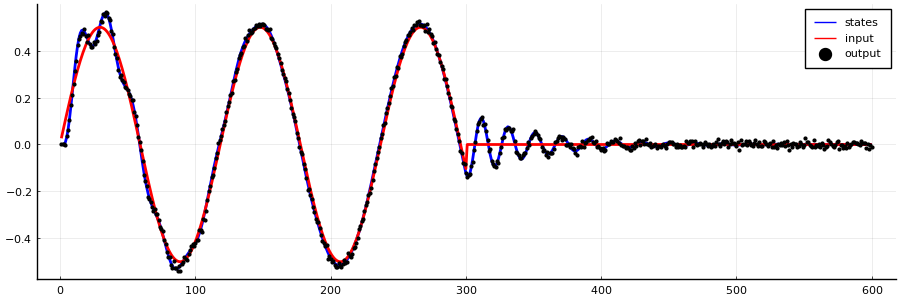

In [5]:
# Time 
T = 600

# Input signal
input = [sin.((1:300)./ (6*π)) ./2; zeros(300,)]
# input = zeros(T,)

# Preallocate arrays
states = zeros(T,)
output = zeros(T,)

for k = 4:T
    output[k], states[k] = sim_sys(input[k], states[[k-1, k-2]], sys_params)
end

p100 = plot(1:T, states, linewidth=2, color="blue", label="states", size=(900,300))
plot!(1:T, input, linewidth=2, color="red", label="input")
scatter!(1:T, output, markersize=2, color="black", label="output")

In [6]:
savefig(p100, "figures/example-input-output_seq1.png")

## Model

We cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{k} \\ x_{k-1} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{k-1} \\ x_{k-2} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{s} g(\theta, z_{k-1}) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} w_t \, ,$$

with $g(\theta, z_{k-1}) = \theta_1 x_{k-1} + \theta_2 x_{k-2}$ and $w_k \sim \mathcal{N}(0, \zeta^{-1})$. The system is now a nonlinear autoregressive process:

$$z_k = f(\theta, z_{k-1}, \eta, u_k) + w_k$$

where $f(\theta, z_{k-1}, \eta, u_k) = S z_{k-1} + s g(\theta, z_{k-1}) + s \eta u_k$.

### Likelihood

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_k \sim&\ \mathcal{N}(f(\theta, z_{k-1}, \eta, u_k), V(\zeta)) \\
y_k \sim&\ \mathcal{N}(s^{\top} z_k, \xi^{-1}) \, ,
\end{align}$$

where $V(\zeta) = \begin{bmatrix} \zeta^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W(\zeta) = V(\zeta)^{-1} = \begin{bmatrix} \zeta & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion;

$$ g(\theta, x) = g(m_{\theta}, m_x) + J_{x}(m_{\theta}, m_x)^{\top}(x - m_x) + J_{\theta}(m_{\theta}, m_x)^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and one could argue that the approximation is unnecessary. However, this form is more general and the first-order Taylor is exact anyway.

### Priors

We choose the following priors:

$$\begin{align}
p(\theta) = \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\zeta)= \text{Gamma}(a^{0}_\zeta, b^{0}_\zeta) \, , \quad
p(\xi)= \text{Gamma}(a^{0}_\xi, b^{0}_\xi) \, .
\end{align}$$

### Recognition model

The recognition model will follow the generative model:

$$\begin{align}
q(\theta) = \text{Normal}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \text{Normal}(m_{\eta}, v_{\eta}) \ , \quad  
q(\zeta)= \text{Gamma}(a_\zeta, b_\zeta) \, , \quad
q(\xi)= \text{Gamma}(a_\xi, b_\xi) \, .
\end{align}$$

### Variational free energy

#TODO

In [7]:
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Optim
using ForneyLab
using NLARX

In [8]:
include("util.jl");

In [9]:
graph1 = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))

# Noise precisions
@RV ζ ~ Gamma(placeholder(:a_ζ), placeholder(:b_ζ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV x ~ GaussianMeanPrecision(placeholder(:m_x, dims=(2,)), placeholder(:w_x, dims=(2, 2)), id=:x_k)

# Nonlinearity
g(θ, z) = θ[1]*z[1] + θ[2]*z[2]

# Autoregressive state transition
@RV z ~ NLatentAutoregressiveX(θ, x, η, placeholder(:u), ζ, g=g, id=:z_k)

# Likelihood
@RV y ~ GaussianMeanPrecision(dot([1. , 0.], z), ξ, id=:y_k)
placeholder(y, :y);

# Specify recognition model
q = PosteriorFactorization(z, x, θ, η, ζ, ξ, ids=[:z, :x, :θ, :η, :ζ, :ξ])

# Specify and compile message passing algorithm
algo = messagePassingAlgorithm([z, x, θ, η, ζ, ξ], q, free_energy=true)
eval(Meta.parse(algorithmSourceCode(algo, free_energy=true)));

### Experiment 1: Online system Identification from known inputs

In [10]:
# Time horizon
T = 1000

# Design input signal
inputs = sin.(pi * range(1, stop=T) / 12) ./ 2;

In [11]:
# Preallocation
states = zeros(T,)
outputs = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=eye(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=eye(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=ones(2,)./2, w=.1 .*eye(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=.1, w=.1)
marginals[:ζ] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e6, b=1e3)

# Number of variational updates
num_iterations = 10

# Initialize free energy tracking array
F = zeros(T, num_iterations)

# Track estimated states
est_states = (zeros(T,), zeros(T,))
check_m = zeros(T,)
check_s = zeros(T,)

@showprogress for k = 3:T
    
    # Execute input and observe output
    outputs[k], states[k] = sim_sys(inputs[k], states[[k-1,k-2]], sys_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => outputs[k],
                       :u => inputs[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_ζ => marginals[:ζ].params[:a],
                       :b_ζ => marginals[:ζ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepη!(constraints, marginals)
        stepθ!(constraints, marginals)
        
        # Update states
        stepz!(constraints, marginals)
#         stepx!(constraints, marginals)
        
        # Update noise precisions
#         stepζ!(constraints, marginals)
#         stepξ!(constraints, marginals)
        
        # Compute free energy
        F[k,ii] = freeEnergy(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k] = mn(marginals[:z])[1]
    est_states[2][k] = sqrt(inv(pc(marginals[:z])[1,1]))
    
    check_m[k] = mn(marginals[:θ])[1]
    check_s[k] = sqrt(inv(pc(marginals[:θ])[1,1]))
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22m


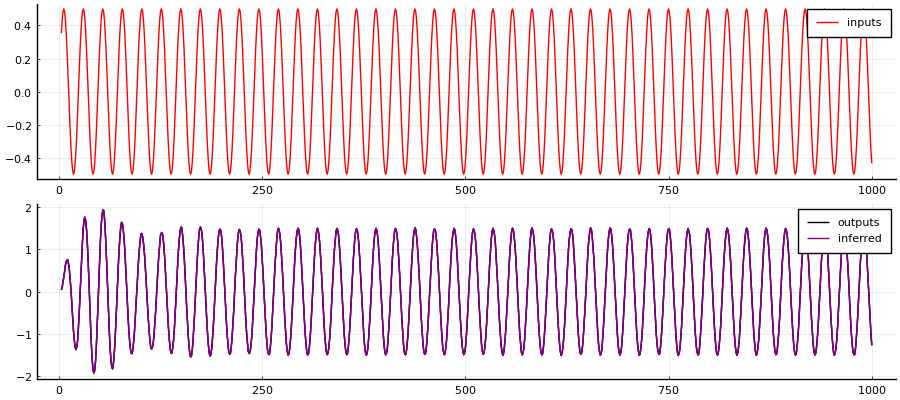

In [12]:
p1 = plot(3:T, inputs[3:T], color="red", label="inputs")
p2 = plot(3:T, outputs[3:T], markersize=1, color="black", label="outputs")
plot!(3:T, est_states[1][3:T], color="purple", label="inferred")
plot!(3:T, est_states[1][3:T], ribbon=[est_states[2][3:T], est_states[2][3:T]], color="purple", label="")
plot(p1, p2, layout=(2,1), size=(900,400))

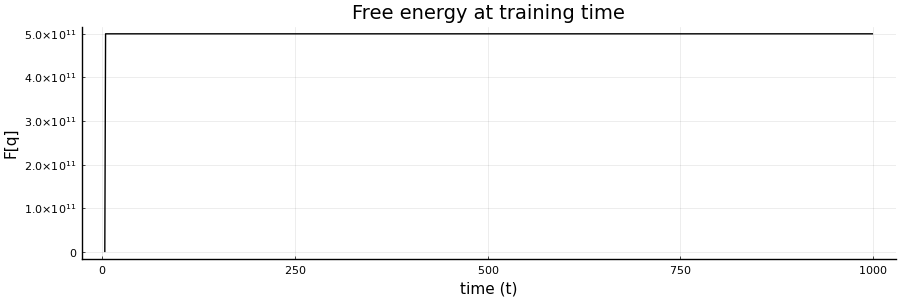

In [13]:
# FE during training
p24 = plot(3:T, F[3:T,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy at training time", size=(900,300))

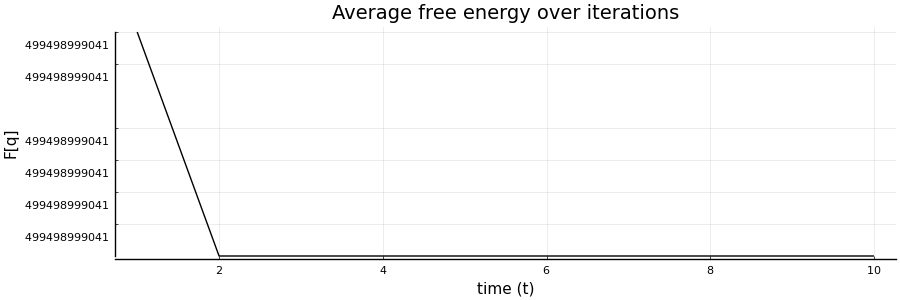

In [14]:
# Average FE during training
p34 = plot(mean(F[3:T,:], dims=1)', color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Average free energy over iterations", size=(900,300))

#### Validate identified system

We validate the identified system by computing simulation error on the validation set.

In [15]:
# Time horizon
T_val = 1000

# Input signal
# inputs_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val];
inputs_val = sin.(pi*range(1,stop=T_val) / 24 .+ 1.) ./ 2;

In [16]:
# Prediction graph
graph = FactorGraph()

# Autoregressive node
@RV z ~ NLatentAutoregressiveX(placeholder(:θ, dims=(2,)), placeholder(:x, dims=(2,)), placeholder(:η), placeholder(:u), placeholder(:ζ), g=g, id=:z_pred)

# Inference algorithm
q = PosteriorFactorization(z, ids=[:_pred])
algo = messagePassingAlgorithm([z], q)
eval(Meta.parse(algorithmSourceCode(algo)));

In [17]:
# Preallocate arrays
states_val = zeros(T_val,)
outputs_val = zeros(T_val,)

# Initialize marginal
marginals[:pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=eye(2))

# Preallocate prediction arrays
preds = (zeros(T_val,), zeros(T_val,))

@showprogress for k = 3:T_val
    
    # Simulate forward
    outputs_val[k], states_val[k] = sim_sys(inputs_val[k], states_val[[k-1,k-2]], sys_params)

    # Update constraints
#     constraints = Dict(:u => inputs_val[k],
#                        :x => mn(marginals[:z]),
#                        :θ => mn(marginals[:θ]),
#                        :η => mn(marginals[:η]),
#                        :ζ => mn(marginals[:ζ]))

#     # Update prediction
#     step_pred!(constraints, marginals)

    # Track predictions
#     preds[1][k] = mn(marginals[:z])[1]
#     preds[2][k] = sqrt(inv(pc(marginals[:z])[1,1]))
    
    # Inferred prior states
    z_kmin1 = preds[1][[k-1,k-2]]
    
    # Posterior predictive
    preds[1][k] = g(mn(marginals[:θ]), z_kmin1) + mn(marginals[:η])*inputs_val[k]
    preds[2][k] = z_kmin1'*pc(marginals[:θ])*z_kmin1 + inputs_val[k]'*pc(marginals[:η])*inputs_val[k] + mn(marginals[:ξ])

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


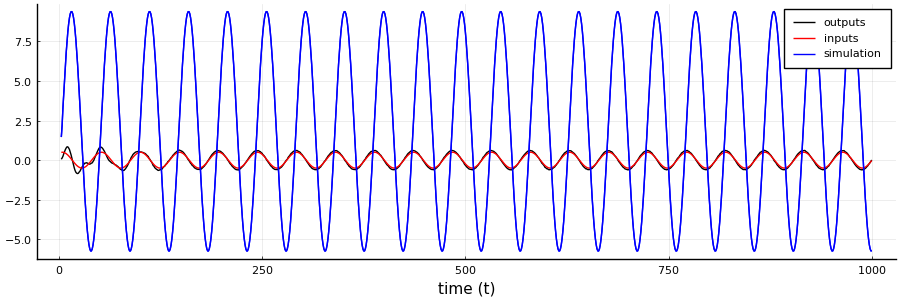

In [18]:
# Plot predictions
p23 = plot(3:T_val, outputs_val[3:T_val], label="outputs", xlabel="time (t)", color="black", size=(900,300))
plot!(3:T_val, inputs_val[3:T_val], label="inputs", color="red")
plot!(3:T_val, preds[1][3:T_val], label="simulation", color="blue")
plot!(3:T_val, preds[1][3:T_val], ribbon=[sqrt.(inv.(preds[2][3:T_val])), sqrt.(inv.(preds[2][3:T_val]))], label="", color="blue")

In [19]:
Plots.savefig(p23, "figures/simulations.png")

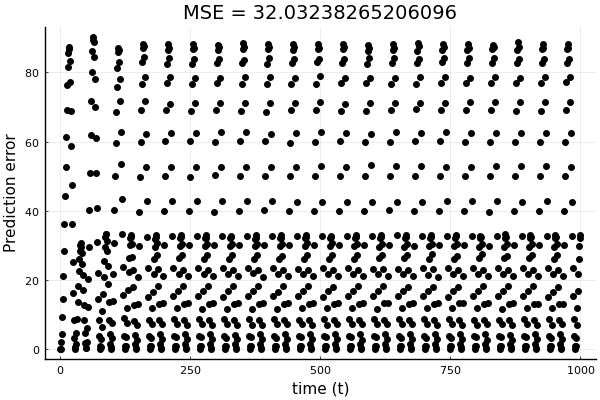

In [20]:
# Compute prediction error
sq_pred_error = (preds[1] .- outputs_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))

In [21]:
Plots.savefig(p24, "figures/sim-errors.png")

### Experiment 2: Agent regulates oscillator's position

In [22]:
function EFE(action, prior_state, goal_state, model_params, g)

    # Unpack model parameters
    θ, η, ζ, ξ = model_params

    # Process noise
    Σ_z = inv(ζ) *[1.  0.; 0.  0.]

    # Helper matrices
    S = [0. 0.; 1. 0.]
    s = [1.; 0.]

    # Start previous state var        
    μ_kmin = prior_state[1]
    Σ_kmin = prior_state[2]

    # State transition
    μ_k = S*μ_kmin + s*g(θ, μ_kmin) + s*η*action[1]
    Σ_k = Σ_kmin + Σ_z

    # calculate the covariance matrix
    Σ_11 = Σ_k
    Σ_21 = s'*Σ_k
    Σ_12 = Σ_k*s
    Σ_22 = s'*Σ_k*s .+ inv(ξ)

    # Calculate conditional entropy
    Σ_cond = Σ_22 - Σ_21 * inv(Σ_11) * Σ_12
    ambiguity = 0.5(log2π + log(Σ_cond[1]) + 1)

    # Calculate marginal mean of observations
    y_hat = s'*μ_k

    # Risk as KL between marginal and goal prior
    risk = KLDivergence(goal_state[1], goal_state[2], y_hat, Σ_22[1])

    # Update loss.
    return risk + ambiguity
end

EFE (generic function with 1 method)

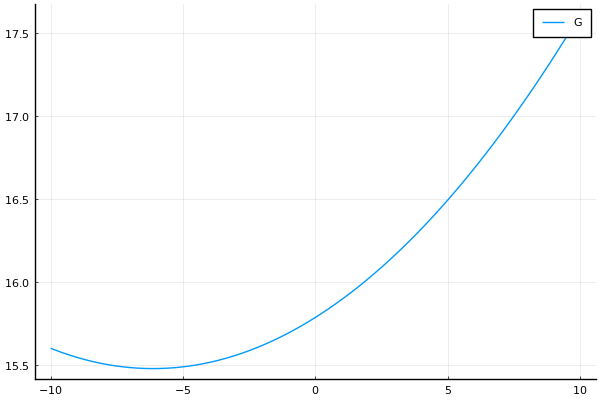

In [23]:
# Test EFE objective
prior_state = (ones(2,)./10, .1 .*eye(2))
model_params = (rand(3,), rand(1,)[1], 1, 1)
G(π) = EFE(π, prior_state, (-1., 1e-6), model_params, g)
test = range(-10, stop=10, length=100)
Gtest = G.(test)
plot(test, G.(test), label="G")

In [24]:
results = optimize(G, randn(1,), GradientDescent(), Optim.Options(show_trace=true, iterations=1000); autodiff=:forward)
Optim.minimizer(results)

Iter     Function value   Gradient norm 
     0     1.590949e+01     1.191859e-01
 * time: 0.07999992370605469
     1     1.547639e+01     3.924395e-17
 * time: 5.523999929428101


1-element Vector{Float64}:
 -6.13468846409404

In [25]:
# Time horizon
T = 400
    
# Goal state (mean and std dev)
goal_state = (.5, 1e-6)

# Planning horizon
plan_horizon = 1

# Number of variational updates
num_iterations = 10

# Preallocation
inputs = zeros(T,)
states = zeros(T,)
outputs = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=eye(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=eye(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=rand(3,), w=.1 .*eye(3))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=rand(1,)[1], w=.1)
marginals[:ζ] = ProbabilityDistribution(Univariate, Gamma, a=1, b=1e-3)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e6, b=1e3)

# Initialize free energy tracking array
F = zeros(T, num_iterations)

# Track estimated states
est_states = (zeros(T,), zeros(T,))

@showprogress for k = 3:T
    
    "Find control"

    # Pack parameters estimated by model
    model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:ζ]), mn(marginals[:ξ]))

    # State prior variable
    prior_state = (mn(marginals[:z]), pc(marginals[:z]))

    # Objective function
    G(π) = EFE(π, prior_state, goal_state, model_params, g, time_horizon=plan_horizon)

    # Miminimize EFE
    results = optimize(G, -1, 1, zeros(plan_horizon,), Fminbox(LBFGS()), Optim.Options(show_trace=false, iterations=1000); autodiff=:forward)
#         results = optimize(G, randn(plan_horizon,), GradientDescent(), Optim.Options(show_trace=false, iterations=1000); autodiff=:forward)
#     results = optimize(G, rand(plan_horizon,), SimulatedAnnealing(), Optim.Options(x_tol=1e-6, show_trace=true, iterations=1000))

    # Select first action in policy
    inputs[k] = Optim.minimizer(results)[1]
    
    "Execute control"
    
    # Execute input and observe output
    outputs[k], states[k] = sim_sys(inputs[k], states[[k-1,k-2]], sys_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => outputs[k],
                       :u => inputs[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_ζ => marginals[:ζ].params[:a],
                       :b_ζ => marginals[:ζ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepη!(constraints, marginals)
        stepθ!(constraints, marginals)
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update noise precisions
        stepζ!(constraints, marginals)
        stepξ!(constraints, marginals)
        
        # Compute free energy
        F[k,ii] = freeEnergy(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k] = mn(marginals[:z])[1]
    est_states[2][k] = sqrt(inv(pc(marginals[:z])[1,1]))
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


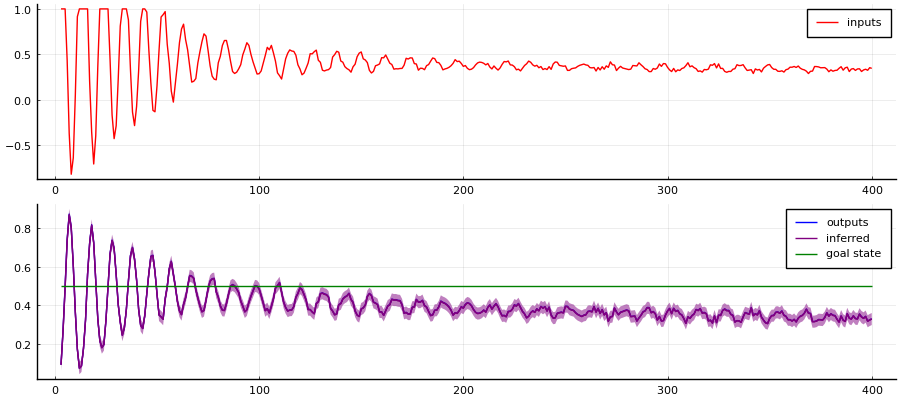

In [26]:
p1 = plot(3:T, inputs[3:T], color="red", label="inputs")
p2 = plot(3:T, outputs[3:T], color="blue", label="outputs")
plot!(3:T, est_states[1][3:T], color="purple", label="inferred")
plot!(3:T, est_states[1][3:T], ribbon=[est_states[2][3:T], est_states[2][3:T]], color="purple", label="")
plot!(3:T, goal_state[1]*ones(T-2,), color="green", label="goal state")
plot(p1, p2, layout=(2,1), size=(900,400))

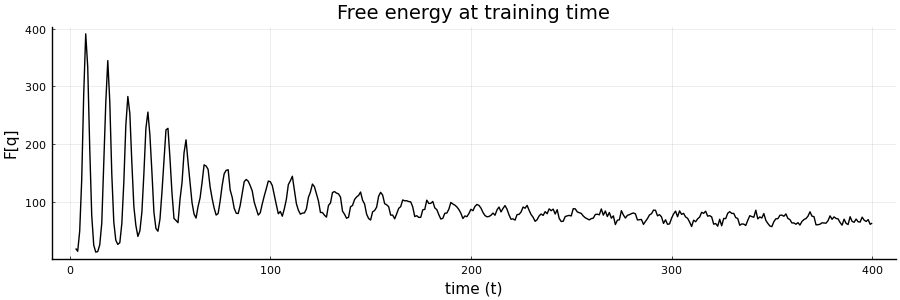

In [27]:
# FE during training
p24 = plot(3:T, F[3:T,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy at training time", size=(900,300))